In [1]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from scipy.special import expit
from joblib import Parallel, delayed
import time

In [6]:
d = 10
N = [50, 100, 200, 400]
T = 200  
B = 200 

quantile = 0.1
degrees_of_freedom = d
quantile_value = chi2.ppf(1 - quantile, degrees_of_freedom)

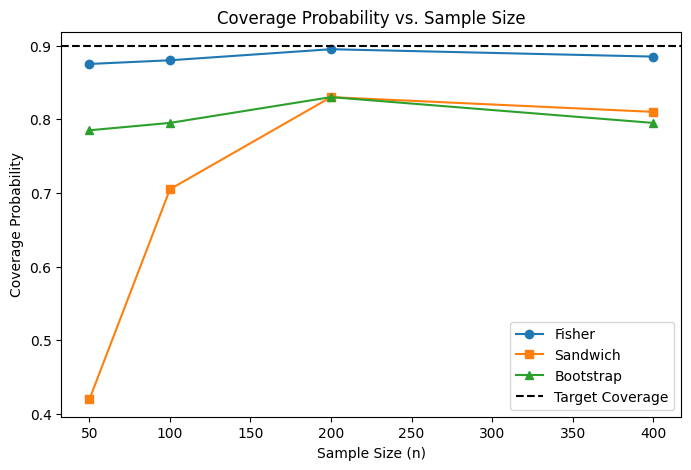

In [3]:


# Storage for coverage probabilities
coverage_fisher = []
coverage_sandwich = []
coverage_bootstrap = []

np.random.seed(42)  # Ensuring reproducibility

def compute_coverage(n, d, T, B):
    fisher_count, sandwich_count, bootstrap_count = 0, 0, 0

    for _ in range(T):
        # Generate data
        X = np.random.normal(0, 1, (d, n))
        
        # Sample true beta from unit sphere
        beta_true = np.random.randn(d)
        beta_true /= np.linalg.norm(beta_true)

        # Compute Yi
        epsilon = np.random.normal(0, 1, n)
        Y = X.T @ beta_true + epsilon

        # Compute beta_hat
        XTX_inv = np.linalg.inv(X @ X.T)  
        beta_hat = XTX_inv @ X @ Y

        # Compute covariance estimates
        residuals = Y - X.T @ beta_hat
        sample_var = np.sum(residuals**2) / (n - d)
        fisher_cov = sample_var * XTX_inv

        temp = X @ np.diag(residuals)
        sandwich_cov = XTX_inv @ (temp @ temp.T) @ XTX_inv

        # Bootstrap covariance
        indices = np.random.choice(n, (B, n), replace=True)
        beta_boots = np.zeros((d, B))

        for b in range(B):
            X_boot = X[:, indices[b, :]]
            Y_boot = Y[indices[b, :]]
            beta_boot = np.linalg.inv(X_boot @ X_boot.T) @ X_boot @ Y_boot
            beta_boots[:, b] = beta_boot
        
        bootstrap_cov = np.cov(beta_boots, ddof=1)

        # Confidence region checks
        fisher_covered = (beta_true - beta_hat).T @ np.linalg.inv(fisher_cov) @ (beta_true - beta_hat) <= quantile_value
        sandwich_covered = (beta_true - beta_hat).T @ np.linalg.inv(sandwich_cov) @ (beta_true - beta_hat) <= quantile_value
        bootstrap_covered = (beta_true - beta_hat).T @ np.linalg.inv(bootstrap_cov) @ (beta_true - beta_hat) <= quantile_value

        fisher_count += fisher_covered
        sandwich_count += sandwich_covered
        bootstrap_count += bootstrap_covered

    return fisher_count / T, sandwich_count / T, bootstrap_count / T

# Run experiments for different sample sizes
for n in N:
    fisher_cov, sandwich_cov, bootstrap_cov = compute_coverage(n, d, T, B)
    coverage_fisher.append(fisher_cov)
    coverage_sandwich.append(sandwich_cov)
    coverage_bootstrap.append(bootstrap_cov)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(N, coverage_fisher, label="Fisher", marker="o")
plt.plot(N, coverage_sandwich, label="Sandwich", marker="s")
plt.plot(N, coverage_bootstrap, label="Bootstrap", marker="^")
plt.axhline(1 - quantile, linestyle="dashed", color="black", label="Target Coverage")
plt.xlabel("Sample Size (n)")
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability vs. Sample Size")
plt.legend()
plt.show()


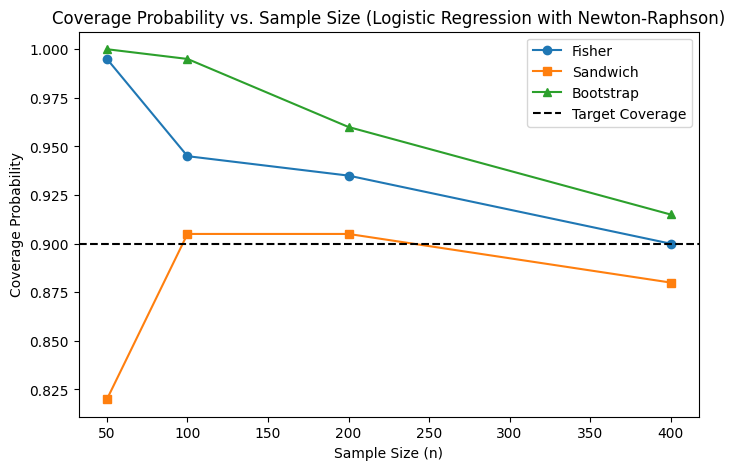

In [4]:
def newton_raphson_logistic(X, Y, max_iter=100, tol=1e-6):
    """Find MLE for logistic regression using Newton-Raphson method."""
    d, n = X.shape
    beta = np.zeros(d)

    for _ in range(max_iter):
        linear_term = np.clip(X.T @ beta, -20, 20)  # Prevent overflow
        p = expit(linear_term)

        # Compute gradient and Hessian
        gradient = X @ (p - Y)
        W = np.diag(p * (1 - p))  # Weight matrix
        hessian = X @ W @ X.T + np.eye(d) * 1e-6  # Regularization

        # Newton-Raphson update step
        beta_new = beta - np.linalg.solve(hessian, gradient)

        # Convergence check
        if np.linalg.norm(beta_new - beta, ord=2) < tol:
            break
        beta = beta_new

    return beta

def compute_logistic_coverage_newton(n, d, T, B):
    fisher_count, sandwich_count, bootstrap_count = 0, 0, 0

    for _ in range(T):

        # Sample data
        X = np.random.normal(0, 1, (d, n))
        beta_true = np.random.randn(d)
        beta_true /= np.linalg.norm(beta_true)

        # Generate binary outcomes using logistic model
        probabilities = expit(X.T @ beta_true)
        Y = np.random.binomial(1, probabilities)

        # Estimate beta_hat using Newton-Raphson method
        beta_hat = newton_raphson_logistic(X, Y)

        # Compute Fisher covariance
        p_hat = expit(X.T @ beta_hat)
        W = np.diag(p_hat * (1 - p_hat))
        fisher_cov = np.linalg.inv(X @ W @ X.T + np.eye(d) * 1e-6)  # Regularized inverse

        # Compute Sandwich covariance
        score = X * (Y - p_hat)
        sandwich_cov = np.linalg.inv(X @ W @ X.T + np.eye(d) * 1e-6) @ (score @ score.T) @ np.linalg.inv(X @ W @ X.T + np.eye(d) * 1e-6)

        # Bootstrap covariance (Parallelized)
        def bootstrap_estimate(b):
            sample_indices = np.random.choice(n, n, replace=True)
            X_boot = X[:, sample_indices]
            Y_boot = Y[sample_indices]
            return newton_raphson_logistic(X_boot, Y_boot)
        
        beta_boots = np.array(Parallel(n_jobs=-1)(delayed(bootstrap_estimate)(b) for b in range(B))).T
        bootstrap_cov = np.cov(beta_boots, ddof=1)

        # Confidence region checks
        fisher_covered = (beta_true - beta_hat).T @ np.linalg.inv(fisher_cov + np.eye(d) * 1e-6) @ (beta_true - beta_hat) <= quantile_value
        sandwich_covered = (beta_true - beta_hat).T @ np.linalg.inv(sandwich_cov + np.eye(d) * 1e-6) @ (beta_true - beta_hat) <= quantile_value
        bootstrap_covered = (beta_true - beta_hat).T @ np.linalg.inv(bootstrap_cov + np.eye(d) * 1e-6) @ (beta_true - beta_hat) <= quantile_value

        fisher_count += fisher_covered
        sandwich_count += sandwich_covered
        bootstrap_count += bootstrap_covered

    return fisher_count / T, sandwich_count / T, bootstrap_count / T

# Run experiments for logistic regression with Newton-Raphson optimization
coverage_fisher_logistic, coverage_sandwich_logistic, coverage_bootstrap_logistic = [], [], []
for n in N:
    fisher_cov, sandwich_cov, bootstrap_cov = compute_logistic_coverage_newton(n, d, T, B)
    coverage_fisher_logistic.append(fisher_cov)
    coverage_sandwich_logistic.append(sandwich_cov)
    coverage_bootstrap_logistic.append(bootstrap_cov)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(N, coverage_fisher_logistic, label="Fisher", marker="o")
plt.plot(N, coverage_sandwich_logistic, label="Sandwich", marker="s")
plt.plot(N, coverage_bootstrap_logistic, label="Bootstrap", marker="^")
plt.axhline(1 - quantile, linestyle="dashed", color="black", label="Target Coverage")
plt.xlabel("Sample Size (n)")
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability vs. Sample Size (Logistic Regression with Newton-Raphson)")
plt.legend()
plt.show()


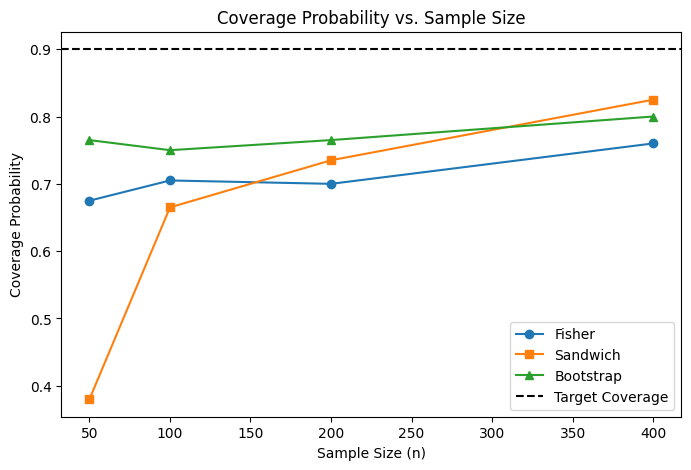

In [14]:


coverage_fisher = []
coverage_sandwich = []
coverage_bootstrap = []


def compute_coverage(n, d, T, B):
    fisher_count, sandwich_count, bootstrap_count = 0, 0, 0

    for _ in range(T):
        # Generate data
        X = np.random.normal(0, 1, (d, n))
        
        # Sample true beta from unit sphere
        beta_true = np.random.randn(d)
        theta_true = np.random.randn(d)
        beta_true /= np.linalg.norm(beta_true)
        theta_true /= np.linalg.norm(theta_true)

        # Compute Yi
        epsilon = np.random.normal(0, 1, n)
        Y = X.T @ beta_true + np.diag(np.diag(X.T @ theta_true) @ np.diag(X.T @ theta_true)) + epsilon

        # Compute beta_hat
        XTX_inv = np.linalg.inv(X @ X.T)  
        beta_hat = XTX_inv @ X @ Y

        # Compute covariance estimates
        residuals = Y - X.T @ beta_hat
        sample_var = np.sum(residuals**2) / (n - d)
        fisher_cov = sample_var * XTX_inv

        temp = X @ np.diag(residuals)
        sandwich_cov = XTX_inv @ (temp @ temp.T) @ XTX_inv

        # Bootstrap covariance
        indices = np.random.choice(n, (B, n), replace=True)
        beta_boots = np.zeros((d, B))

        for b in range(B):
            X_boot = X[:, indices[b, :]]
            Y_boot = Y[indices[b, :]]
            beta_boot = np.linalg.inv(X_boot @ X_boot.T) @ X_boot @ Y_boot
            beta_boots[:, b] = beta_boot
        
        bootstrap_cov = np.cov(beta_boots, ddof=1)

        # Confidence region checks
        fisher_covered = (beta_true - beta_hat).T @ np.linalg.inv(fisher_cov) @ (beta_true - beta_hat) <= quantile_value
        sandwich_covered = (beta_true - beta_hat).T @ np.linalg.inv(sandwich_cov) @ (beta_true - beta_hat) <= quantile_value
        bootstrap_covered = (beta_true - beta_hat).T @ np.linalg.inv(bootstrap_cov) @ (beta_true - beta_hat) <= quantile_value

        fisher_count += fisher_covered
        sandwich_count += sandwich_covered
        bootstrap_count += bootstrap_covered

    return fisher_count / T, sandwich_count / T, bootstrap_count / T

# Run experiments for different sample sizes
for n in N:
    fisher_cov, sandwich_cov, bootstrap_cov = compute_coverage(n, d, T, B)
    coverage_fisher.append(fisher_cov)
    coverage_sandwich.append(sandwich_cov)
    coverage_bootstrap.append(bootstrap_cov)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(N, coverage_fisher, label="Fisher", marker="o")
plt.plot(N, coverage_sandwich, label="Sandwich", marker="s")
plt.plot(N, coverage_bootstrap, label="Bootstrap", marker="^")
plt.axhline(1 - quantile, linestyle="dashed", color="black", label="Target Coverage")
plt.xlabel("Sample Size (n)")
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability vs. Sample Size")
plt.legend()
plt.show()
